- Word Embedding:
  - Turns word into a vector in dimensional space to represent its semantic
  - Words were mapped to vectors in higher dimensional space, and the semantics of the words then learned when those words were labelled with similar meaning.

- IMDB dataset
- IMDB subword dataset
  - 用subword的结果会比普通的差，这一点主要是因为他的subword都是一些比如会把Michael分成mi和cha和el，这样子的subword说实话意义并没有很大。有意义的单词，由subword组成，这就导致了如果一个单词是[3, 1, 2]，在process到后面的2的时候，整体的语义是基于前面的3和1的，也就是说，我们的神经网络需要有记忆
- 如何利用io去写入文件
- 利用<a href="https://projector.tensorflow.org/">projector.tensorflow</a>去可视化embedding的结果

In [112]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.datasets.imdb as imdb_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
# 另一种load data的方式
# (x_train,y_train),(x_test,y_test)=imdb_dataset.load_data()

In [114]:
def to_fit(str1):
  fit_str = [str1]
  predict_str = tokenizer.texts_to_sequences(fit_str)
  return predict_str

In [115]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [116]:
train_data, test_data = imdb["train"], imdb["test"]

In [ ]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())


In [ ]:
vocab_size=10000
embedding_dim=16
max_length = 120
oov_tok="<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print("There are ", len(tokenizer.word_index), " words in the dataset\n")
sequences = tokenizer.texts_to_sequences(training_sentences)
print("There are ", len(sequences), " lines in the sequences\n")
pad_post = pad_sequences(sequences=sequences, maxlen=max_length, padding="post", truncating="post")
print("Padded sequence", pad_post.shape)

test_sequence = tokenizer.texts_to_sequences(testing_sentences)
test_pad_post = pad_sequences(sequences=test_sequence, maxlen=max_length, padding="post", truncating="post")


There are  86539  words in the dataset

There are  25000  lines in the sequences

Padded sequence (25000, 120)


In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work 这里讲了word_embedding背后的逻辑
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                           input_length=max_length),
    # keras.layers.GlobalAveragePooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=6, activation=tf.nn.relu),
    keras.layers.Dense(units=12, activation=tf.nn.relu),
    keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 11526     
_________________________________________________________________
dense_17 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 13        
Total params: 171,623
Trainable params: 171,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(pad_post, np.array(training_labels), validation_split=0.33, epochs=10)

Epoch 1/10
524/524 [==============================] - 4s 7ms/step - loss: 0.5580 - accuracy: 0.6817 - val_loss: 0.4194 - val_accuracy: 0.8142
Epoch 2/10
524/524 [==============================] - 3s 5ms/step - loss: 0.2362 - accuracy: 0.9094 - val_loss: 0.4251 - val_accuracy: 0.8178
Epoch 3/10
524/524 [==============================] - 3s 5ms/step - loss: 0.0573 - accuracy: 0.9868 - val_loss: 0.5363 - val_accuracy: 0.8118
Epoch 4/10
524/524 [==============================] - 3s 5ms/step - loss: 0.0114 - accuracy: 0.9983 - val_loss: 0.6433 - val_accuracy: 0.8105
Epoch 5/10
524/524 [==============================] - 3s 5ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.7027 - val_accuracy: 0.8136
Epoch 6/10
524/524 [==============================] - 3s 5ms/step - loss: 7.2834e-04 - accuracy: 1.0000 - val_loss: 0.7501 - val_accuracy: 0.8137
Epoch 7/10
524/524 [==============================] - 3s 5ms/step - loss: 3.6667e-04 - accuracy: 1.0000 - val_loss: 0.7874 - val_accuracy: 0.813

<Figure size 432x288 with 0 Axes>

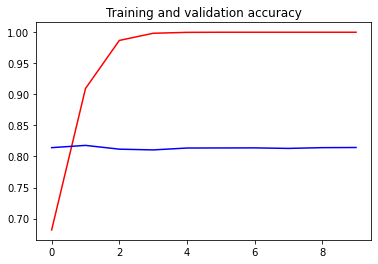

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.figure()

In [ ]:
# 可视化embedding的结果

e = model.layers[0]
weights = e.get_weights()[0]
print("Dimension for weights: ", weights.shape)

## reverse word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


Dimension for weights:  (10000, 16)


In [ ]:
# 把数据写入文件
import io

out_v = io.open("/tmp/vecs.tsv", "w", encoding="utf-8")
out_m = io.open("/tmp/meta.tsv", "w", encoding="utf-8")

for word_num in range(1, vocab_size):
  ## 所以刚刚reverse的原因在于现在可以轻松点把它提取出来
  word = reverse_word_index[word_num]
  embedding = weights[word_num]
  out_m.write(word+"\n")
  out_v.write("\t".join([str(x) for x in embedding]) + "\n")
out_m.close()
out_v.close()

In [ ]:
# 下载文件
try:
  from gooogle.colab import files
except ImportError:
  pass
else:
  files.download("/tmp/vecs.tsv")
  files.download("/tmp/mata.tsv")